<a href="https://colab.research.google.com/github/Debadatta419/6G-Channel-Estimation-Dataset-and-Defensive-Distillation-Based-Adversarial-Security/blob/main/Channel_Estimation_Adversarial_Defensive_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow scipy matplotlib numpy

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
#Create project folder structure
import os

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("Folders created ")


Folders created 


In [15]:
#imports and global config

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

import scipy.io as sio  # only needed if you ever load .mat files

print("TF version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# === Global config ===
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

N_SUBC = 612      # subcarriers
N_SYM = 14        # OFDM symbols
N_FEAT = 2        # real + imag
INPUT_SHAPE = (N_SUBC, N_SYM, N_FEAT)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BATCH_SIZE = 8
LR = 1e-3

def nmse(y_true, y_pred):
    """
    Normalized Mean Squared Error over (subc, sym, feat)
    y_true, y_pred: numpy arrays of shape (N, 612, 14, 2)
    """
    num = np.sum((y_true - y_pred) ** 2, axis=(1, 2, 3))
    den = np.sum((y_true) ** 2, axis=(1, 2, 3)) + 1e-12
    return float(np.mean(num / den))


TF version: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
#Dataset loader + synthetic generator
def load_dataset_npz(path):
    data = np.load(path)
    X = data["X"].astype("float32")
    Y = data["Y"].astype("float32")
    print("Loaded dataset from:", path)
    print("X shape:", X.shape, "Y shape:", Y.shape)
    return X, Y


def generate_synthetic_dataset(n_samples=1024, snr_db_range=(0, 10)):
    """
    Simple synthetic SISO channel: Rayleigh fading + AWGN.
    Shapes follow 612 x 14 x 2 (real, imag).
    """
    X = np.zeros((n_samples, N_SUBC, N_SYM, N_FEAT), dtype=np.float32)
    Y = np.zeros_like(X)

    for i in range(n_samples):
        # Random complex channel per subcarrier/symbol
        h_real = np.random.normal(size=(N_SUBC, N_SYM))
        h_imag = np.random.normal(size=(N_SUBC, N_SYM))
        h = h_real + 1j * h_imag

        # Random SNR between provided range
        snr_db = np.random.uniform(*snr_db_range)
        snr_lin = 10 ** (snr_db / 10.0)
        noise_std = np.sqrt(1 / (2 * snr_lin))

        noise = noise_std * (
            np.random.normal(size=h.shape) + 1j * np.random.normal(size=h.shape)
        )

        y = h + noise

        # Store as real/imag feature maps
        X[i, ..., 0] = np.real(y)
        X[i, ..., 1] = np.imag(y)
        Y[i, ..., 0] = np.real(h)
        Y[i, ..., 1] = np.imag(h)

    print("Synthetic dataset generated ")
    return X, Y


# === Load or generate dataset ===
npz_path = DATA_DIR / "channel_dataset.npz"

if npz_path.exists():
    X, Y = load_dataset_npz(str(npz_path))
else:
    print("No NPZ dataset found, generating synthetic data instead…")
    X, Y = generate_synthetic_dataset(n_samples=1024, snr_db_range=(0, 10))

print("Final dataset shape:", X.shape, Y.shape)


No NPZ dataset found, generating synthetic data instead…
Synthetic dataset generated 
Final dataset shape: (1024, 612, 14, 2) (1024, 612, 14, 2)


In [6]:
# Train/val/test split
N = X.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

train_end = int(0.8 * N)
val_end = int(0.9 * N)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape, Y_val.shape)
print("Test: ", X_test.shape, Y_test.shape)


Train: (819, 612, 14, 2) (819, 612, 14, 2)
Val:   (102, 612, 14, 2) (102, 612, 14, 2)
Test:  (103, 612, 14, 2) (103, 612, 14, 2)


In [7]:
# CNN channel estimator model
def build_cnn_estimator(input_shape=INPUT_SHAPE):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    out = layers.Conv2D(2, (1, 1), padding="same", activation=None)(x)  # real + imag

    model = models.Model(inp, out, name="cnn_estimator")
    return model


baseline_model = build_cnn_estimator()
baseline_model.compile(optimizer=optimizers.Adam(LR), loss="mse")

baseline_model.summary()


Model: "cnn_estimator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 612, 14, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 612, 14, 32)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 612, 14, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 612, 14, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 612, 14, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 612, 14, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 612, 14, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 612, 14, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 612, 14, 2)     │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,202 (293.76 KB)

 Trainable params: 74,882 (292.51 KB)

 Non-trainable params: 320 (1.25 KB)

In [23]:
# Train baseline & evaluate on clean data
EPOCHS_BASELINE = 5  # increase to 20–50 later for better performance

history_baseline = baseline_model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS_BASELINE,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Y_pred_clean = baseline_model.predict(X_test, batch_size=BATCH_SIZE)
baseline_nmse_clean = nmse(Y_test, Y_pred_clean)

print("Baseline Test NMSE (clean):", baseline_nmse_clean)


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1682 - val_loss: 0.1791
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1666 - val_loss: 0.1776
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1655 - val_loss: 0.1765
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1646 - val_loss: 0.1756
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1639 - val_loss: 0.1749
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Baseline Test NMSE (clean): 0.17056894302368164


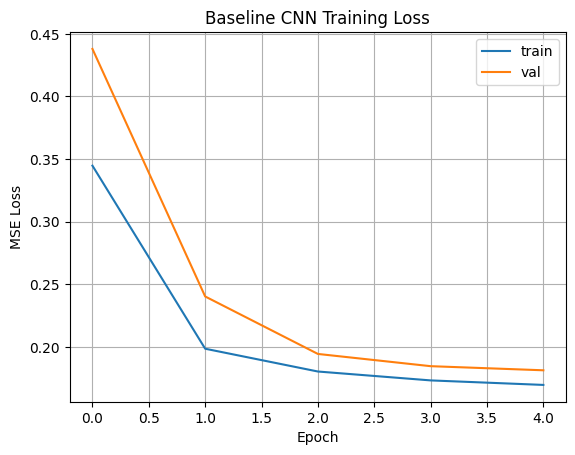

In [9]:
#plots of training loss
plt.figure()
plt.plot(history_baseline.history["loss"], label="train")
plt.plot(history_baseline.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Baseline CNN Training Loss")
plt.legend()
plt.grid(True)
plt.show()


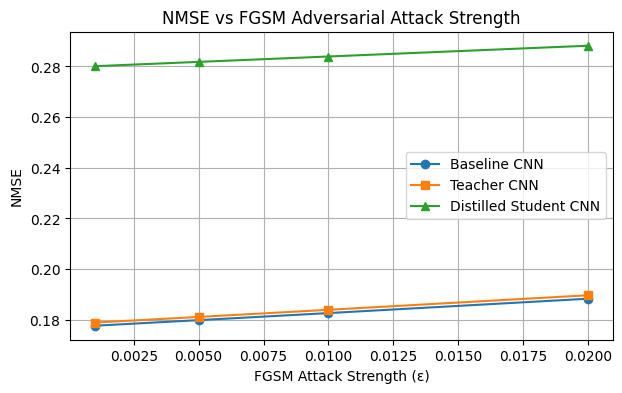

In [16]:
# NMSE vs Attack Strength (FGSM ε)
eps_vals = [r[0] for r in results]
nmse_baseline = [r[1] for r in results]
nmse_teacher = [r[2] for r in results]
nmse_student = [r[3] for r in results]

plt.figure(figsize=(7,4))
plt.plot(eps_vals, nmse_baseline, marker='o', label='Baseline CNN')
plt.plot(eps_vals, nmse_teacher, marker='s', label='Teacher CNN')
plt.plot(eps_vals, nmse_student, marker='^', label='Distilled Student CNN')

plt.xlabel("FGSM Attack Strength (ε)")
plt.ylabel("NMSE")
plt.title("NMSE vs FGSM Adversarial Attack Strength")
plt.grid(True)
plt.legend()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


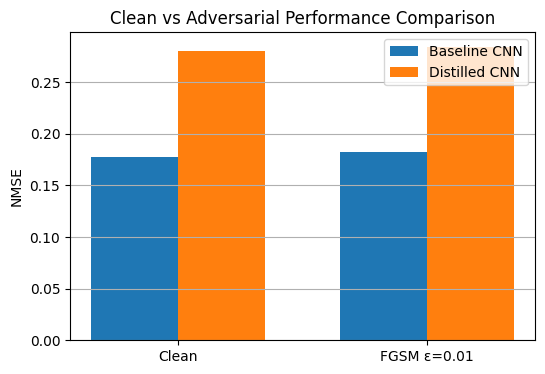

In [17]:
# Clean vs Adversarial NMSE
labels = ["Clean", "FGSM ε=0.01"]

baseline_vals = [
    baseline_nmse_clean,
    evaluate_fgsm(baseline_model, X_test, Y_test, eps=0.01, batch_size=BATCH_SIZE),
]

student_vals = [
    student_nmse_clean,
    evaluate_fgsm(student_model, X_test, Y_test, eps=0.01, batch_size=BATCH_SIZE),
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, baseline_vals, width, label="Baseline CNN")
plt.bar(x + width/2, student_vals, width, label="Distilled CNN")

plt.ylabel("NMSE")
plt.title("Clean vs Adversarial Performance Comparison")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y')
plt.show()


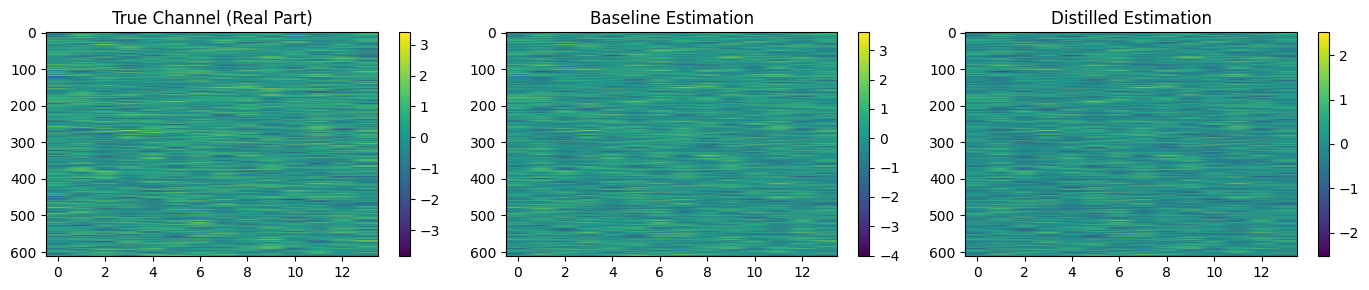

In [18]:
# Channel Estimation Visualization
sample_id = 0  # pick any test sample

true_channel = Y_test[sample_id, :, :, 0]        # real part
baseline_channel = Y_pred_clean[sample_id, :, :, 0]
student_channel = Y_pred_student_clean[sample_id, :, :, 0]

plt.figure(figsize=(14,3))

plt.subplot(1,3,1)
plt.imshow(true_channel, aspect='auto')
plt.title("True Channel (Real Part)")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(baseline_channel, aspect='auto')
plt.title("Baseline Estimation")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(student_channel, aspect='auto')
plt.title("Distilled Estimation")
plt.colorbar()

plt.tight_layout()
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


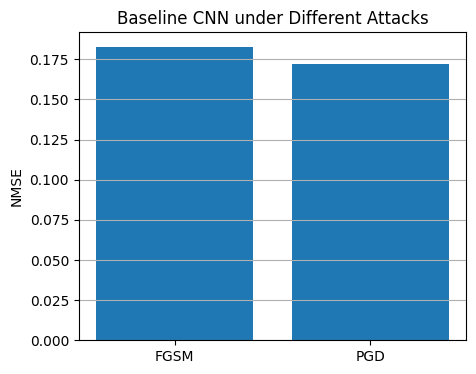

In [19]:
# PGD vs FGSM Attack Comparison
fgsm_nmse = evaluate_fgsm(baseline_model, X_test, Y_test, eps=0.01, batch_size=BATCH_SIZE)
pgd_nmse = nmse(
    Y_sub,
    baseline_model.predict(
        pgd_attack(baseline_model, X_sub, Y_sub, eps=0.01, alpha=0.002, iters=20)
    )
)

plt.figure(figsize=(5,4))
plt.bar(["FGSM", "PGD"], [fgsm_nmse, pgd_nmse])
plt.ylabel("NMSE")
plt.title("Baseline CNN under Different Attacks")
plt.grid(axis='y')
plt.show()


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/3 - Student loss: 0.269851
Epoch 2/3 - Student loss: 0.093990
Epoch 3/3 - Student loss: 0.074003
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/3 - Student loss: 0.231045
Epoch 2/3 - Student loss: 0.119628
Epoch 3/3 - Student loss: 0.106323
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/3 - Student loss: 0.301539
Epoch 2/3 - Student loss: 0.178444
Epoch 3/3 - Student loss: 0.170805
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


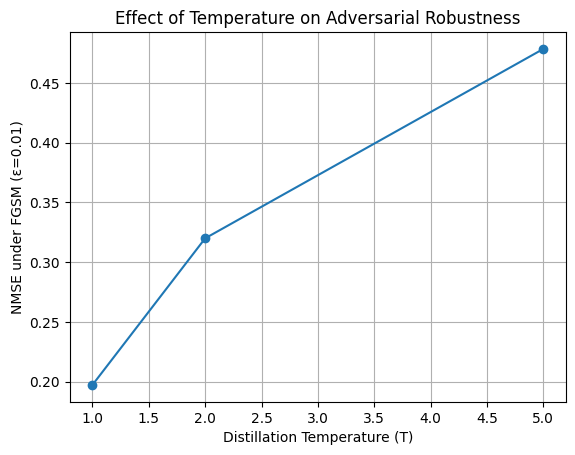

In [20]:
# Temperature (T) vs Robustness
T_values = [1.0, 2.0, 5.0]
student_nmse_adv = []

for T_val in T_values:
    soft_train = create_soft_labels(teacher_model, X_train, temperature=T_val)
    student_tmp = train_student(
        X_train, soft_train, Y_train, alpha=0.7, epochs=3
    )
    nmse_adv = evaluate_fgsm(student_tmp, X_test, Y_test, eps=0.01)
    student_nmse_adv.append(nmse_adv)

plt.figure()
plt.plot(T_values, student_nmse_adv, marker='o')
plt.xlabel("Distillation Temperature (T)")
plt.ylabel("NMSE under FGSM (ε=0.01)")
plt.title("Effect of Temperature on Adversarial Robustness")
plt.grid(True)
plt.show()


In [10]:
# FGSM adversarial attack
@tf.function
def fgsm_attack(model, x, y_true, eps=0.01):
    """
    Fast Gradient Sign Method (FGSM) for regression.
    """
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x, training=False)
        loss = tf.reduce_mean(tf.square(y_pred - y_true))
    grad = tape.gradient(loss, x)
    x_adv = x + eps * tf.sign(grad)
    return x_adv


def evaluate_fgsm(model, X, Y, eps=0.01, batch_size=32):
    X_tf = tf.convert_to_tensor(X)
    Y_tf = tf.convert_to_tensor(Y)
    X_adv = fgsm_attack(model, X_tf, Y_tf, eps=eps)
    Y_adv_pred = model.predict(X_adv, batch_size=batch_size)
    return nmse(Y, Y_adv_pred)


for eps in [0.001, 0.005, 0.01, 0.02]:
    nmse_adv = evaluate_fgsm(baseline_model, X_test, Y_test, eps=eps, batch_size=BATCH_SIZE)
    print(f"FGSM eps={eps:.3f} -> Test NMSE (adversarial): {nmse_adv:.6f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
FGSM eps=0.001 -> Test NMSE (adversarial): 0.177661
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
FGSM eps=0.005 -> Test NMSE (adversarial): 0.179865
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
FGSM eps=0.010 -> Test NMSE (adversarial): 0.182650
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
FGSM eps=0.020 -> Test NMSE (adversarial): 0.188318


In [11]:
# PGD attack (stronger iterative attack)
def pgd_attack(model, x_np, y_np, eps=0.01, alpha=0.002, iters=15):
    """
    Projected Gradient Descent (iterative FGSM) for regression.
    """
    x_orig = tf.convert_to_tensor(x_np)
    y = tf.convert_to_tensor(y_np)
    x_adv = tf.identity(x_orig)

    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            y_pred = model(x_adv, training=False)
            loss = tf.reduce_mean(tf.square(y_pred - y))
        grad = tape.gradient(loss, x_adv)
        x_adv = x_adv + alpha * tf.sign(grad)

        # Project back to epsilon-ball around original
        x_adv = tf.clip_by_value(
            x_orig + tf.clip_by_value(x_adv - x_orig, -eps, eps),
            -1e6,
            1e6,
        )

    return x_adv


# Evaluate PGD on a subset for speed
X_sub = X_test[:64]
Y_sub = Y_test[:64]

X_adv_pgd = pgd_attack(baseline_model, X_sub, Y_sub, eps=0.01, alpha=0.002, iters=20)
Y_adv_pgd_pred = baseline_model.predict(X_adv_pgd, batch_size=BATCH_SIZE)

nmse_pgd = nmse(Y_sub, Y_adv_pgd_pred)
print("PGD (subset) Test NMSE (adversarial):", nmse_pgd)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
PGD (subset) Test NMSE (adversarial): 0.17224493622779846


In [12]:
# Defensive Distillation (Teacher → Student)
# --- Teacher training ---

def train_teacher(X_train, Y_train, X_val, Y_val, epochs=5):
    teacher = build_cnn_estimator()
    teacher.compile(optimizer=optimizers.Adam(LR), loss="mse")
    teacher.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        verbose=1,
    )
    return teacher


print("Training TEACHER model (defensive distillation)…")
teacher_epochs = 5  # increase later
teacher_model = train_teacher(X_train, Y_train, X_val, Y_val, epochs=teacher_epochs)


def create_soft_labels(teacher, X, temperature=2.0):
    """
    For regression: scale outputs with a 'temperature' factor.
    """
    preds = teacher.predict(X, batch_size=BATCH_SIZE)
    if temperature != 1.0:
        preds_T = preds / temperature
    else:
        preds_T = preds
    return preds_T.astype("float32")


T = 2.0  # temperature
soft_train = create_soft_labels(teacher_model, X_train, temperature=T)
soft_val = create_soft_labels(teacher_model, X_val, temperature=T)

print("Soft labels created. Shape:", soft_train.shape)


# --- Student training (distilled) ---

def train_student(
    X_train,
    soft_labels,
    Y_true,
    alpha=0.7,
    epochs=5,
):
    """
    alpha: weight for soft label loss vs true label loss.
    """
    student = build_cnn_estimator()
    optimizer = optimizers.Adam(LR)

    train_ds = (
        tf.data.Dataset.from_tensor_slices((X_train, soft_labels, Y_true))
        .shuffle(1000, seed=SEED)
        .batch(BATCH_SIZE)
    )

    for epoch in range(epochs):
        epoch_losses = []
        for x_batch, s_batch, y_batch in train_ds:
            with tf.GradientTape() as tape:
                preds = student(x_batch, training=True)
                loss_soft = tf.reduce_mean(tf.square(preds - s_batch))
                loss_true = tf.reduce_mean(tf.square(preds - y_batch))
                loss = alpha * loss_soft + (1.0 - alpha) * loss_true
            grads = tape.gradient(loss, student.trainable_variables)
            optimizer.apply_gradients(zip(grads, student.trainable_variables))
            epoch_losses.append(loss.numpy())
        print(f"Epoch {epoch+1}/{epochs} - Student loss: {np.mean(epoch_losses):.6f}")

    return student


print("Training STUDENT model (distilled)…")
student_epochs = 5  # increase later
student_model = train_student(
    X_train,
    soft_train,
    Y_train,
    alpha=0.7,
    epochs=student_epochs,
)


Training TEACHER model (defensive distillation)…
Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.5998 - val_loss: 0.4274
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2112 - val_loss: 0.2418
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1854 - val_loss: 0.1972
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1759 - val_loss: 0.1864
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1713 - val_loss: 0.1825
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Soft labels created. Shape: (819, 612, 14, 2)
Training STUDENT model (distilled)…
Epoch 1/5 - Student loss: 0.241209
Epoch 2/5 - Student loss: 0.121629
Epoch 3/5 - Student loss: 0.107386
Epoch 4/5 - Student loss: 0.102423
Epoch 5/5 - Student loss: 0.100138


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
=== Clean NMSE ===
Baseline: 0.17711319029331207
Teacher : 0.1783403903245926
Student : 0.27967846393585205

=== FGSM Adversarial NMSE Comparison ===
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
eps=0.001 | Baseline=0.17766, Teacher=0.17889, Student=0.28010
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
eps=0.005 | Baseline=0.17987, Teacher=0.18113, Student=0.28180
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
eps=0.010 | Baseline=0.18265, Teacher=0.18394, Student=0.28393
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
eps=0.020 | Baseline=0.18832, Teacher=0.18968, Student=0.28818


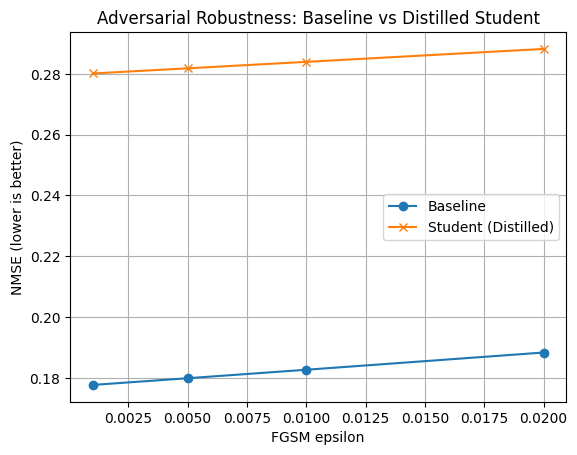

In [13]:
# Compare robustness: teacher vs student vs baseline
# Clean performance
Y_pred_student_clean = student_model.predict(X_test, batch_size=BATCH_SIZE)
student_nmse_clean = nmse(Y_test, Y_pred_student_clean)

Y_pred_teacher_clean = teacher_model.predict(X_test, batch_size=BATCH_SIZE)
teacher_nmse_clean = nmse(Y_test, Y_pred_teacher_clean)

print("=== Clean NMSE ===")
print("Baseline:", baseline_nmse_clean)
print("Teacher :", teacher_nmse_clean)
print("Student :", student_nmse_clean)


# Adversarial performance under FGSM
print("\n=== FGSM Adversarial NMSE Comparison ===")
eps_values = [0.001, 0.005, 0.01, 0.02]

results = []

for eps in eps_values:
    nmse_base = evaluate_fgsm(baseline_model, X_test, Y_test, eps=eps, batch_size=BATCH_SIZE)
    nmse_teacher = evaluate_fgsm(teacher_model, X_test, Y_test, eps=eps, batch_size=BATCH_SIZE)
    nmse_student = evaluate_fgsm(student_model, X_test, Y_test, eps=eps, batch_size=BATCH_SIZE)

    results.append((eps, nmse_base, nmse_teacher, nmse_student))
    print(
        f"eps={eps:.3f} | Baseline={nmse_base:.5f}, "
        f"Teacher={nmse_teacher:.5f}, Student={nmse_student:.5f}"
    )

# Simple plot: NMSE vs eps for baseline & student
eps_arr = [r[0] for r in results]
nmse_base_arr = [r[1] for r in results]
nmse_stu_arr = [r[3] for r in results]

plt.figure()
plt.plot(eps_arr, nmse_base_arr, marker="o", label="Baseline")
plt.plot(eps_arr, nmse_stu_arr, marker="x", label="Student (Distilled)")
plt.xlabel("FGSM epsilon")
plt.ylabel("NMSE (lower is better)")
plt.title("Adversarial Robustness: Baseline vs Distilled Student")
plt.grid(True)
plt.legend()
plt.show()


In [24]:
# Save models & results
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

baseline_model.save("models/baseline_cnn.h5")
teacher_model.save("models/teacher_cnn.h5")
student_model.save("models/student_distilled_cnn.h5")

np.savez(
    "results/eval_results.npz",
    Y_test=Y_test,
    Y_pred_clean_baseline=Y_pred_clean,
    Y_pred_clean_student=Y_pred_student_clean,
)

print("Models and results saved ")


Models and results saved 
